## 앞선 예제(SGD 를 사용한 기본 DNN) 에서 SGD 를 사용하지 않고 Adam 을 사용한 버전

 - 데이터 정규화, 배치 정규화도 하지 않았는데, 학습을 잘함

In [18]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets
import torchvision.utils as vutils

# Tensorboard 없으면 아래 1줄 주석 처리하세요.
from tensorboardX import SummaryWriter

import numpy as np
import random
import matplotlib.pyplot as plt
torch.manual_seed(1)

### 모델 생성

In [19]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.mylayer = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
        )
    def forward(self, x):
        out = self.mylayer(x)
        return out

model = Net()
print(model)

Net(
  (mylayer): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=10, bias=True)
  )
)


### Mnist 데이터 셋 

In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),])

train_dataset = vdatasets.MNIST(root='./MNIST/',
                               train=True, 
                               transform=transform,
                               download=True)

test_dataset = vdatasets.MNIST(root='./MNIST/',
                               train=False, 
                               transform=transform,
                               download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

torch.Size([60000, 28, 28])
torch.Size([10000])


Text(0.5, 1.0, '5')

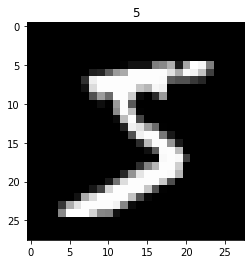

In [21]:
print(train_dataset.data.size())
print(test_dataset.targets.size())

idx=0
plt.imshow(train_dataset.data[idx,:,:].numpy(), cmap='gray')
plt.title('%i' % train_dataset.targets[idx])

torch.Size([64, 1, 28, 28])
torch.Size([64])


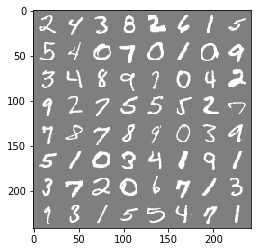

array([2, 4, 3, 8, 2, 6, 1, 5, 5, 4, 0, 7, 0, 1, 0, 9, 3, 4, 8, 9, 7, 0,
       4, 2, 9, 2, 7, 5, 5, 5, 2, 7, 7, 8, 7, 8, 9, 0, 3, 9, 5, 1, 0, 3,
       4, 1, 9, 1, 3, 7, 2, 0, 6, 7, 1, 3, 9, 3, 1, 5, 5, 4, 7, 1])

In [22]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
batch_images, batch_labels = next(iter(train_loader))

print(batch_images.size())
print(batch_labels.size())

#숫자 64개 표시
imshow(vutils.make_grid(batch_images))
batch_labels.numpy()

In [23]:
# 텐서보드
# Tensorboard 없으면 아래 1줄 주석 처리하세요.
writer = SummaryWriter(comment="-DNN_ADAM_WITHOUT_NORM")

### Train

In [24]:
EPOCH = 3
loss_func = nn.CrossEntropyLoss() # Softmax 함수가 내장되어 있음.
lr = 1e-3
optimizer = optim.Adam(params=model.parameters(), lr=lr)
total_Iter = 0

for epoch in range(EPOCH):
    losses = []
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.view(-1, 28*28)
        model.zero_grad()
        preds = model(inputs)
        loss = loss_func(preds, labels.long())
        
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Tensorboard 없으면 아래 3줄 주석 처리하세요.
        total_Iter += 1
        if total_Iter % 10 == 0:
            writer.add_scalar('runs/loss_dnn', loss.item(), total_Iter)
        
    print("[%d/%d] mean_loss : %.3f" % (epoch+1,EPOCH, np.mean(losses)))
    
# Tensorboard 없으면 아래 1줄 주석 처리하세요.
writer.close()

[1/3] mean_loss : 0.489
[2/3] mean_loss : 0.142
[3/3] mean_loss : 0.090


### TEST

In [25]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images  = images.view(-1, 28 * 28)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += 64
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 96 %


### Random pick TEST

In [26]:
r = random.randint(0, len(test_dataset)-1)
X_single_data = test_dataset.data[r:r + 1].view(-1,28*28).float()
Y_single_data = test_dataset.targets[r:r + 1]

Label :  [1]
Prediction :  [1]


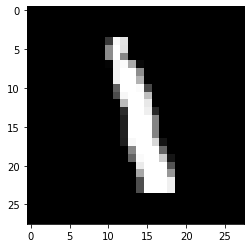

In [27]:
with torch.no_grad():
    single_prediction = model(X_single_data)
    plt.imshow(X_single_data.data.view(28,28).numpy(), cmap='gray')

    print('Label : ', Y_single_data.data.view(1).numpy())
    print('Prediction : ', torch.max(single_prediction.data, 1)[1].numpy())

### Features of Node

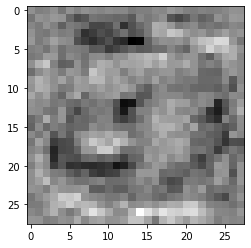

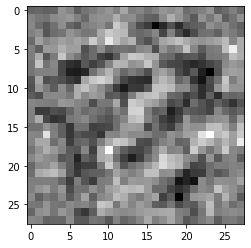

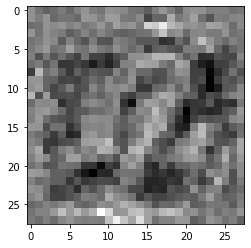

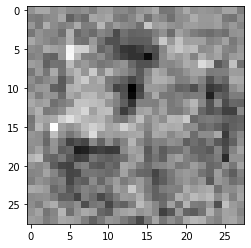

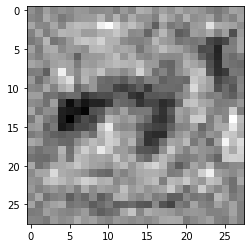

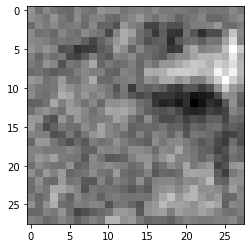

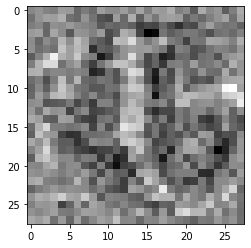

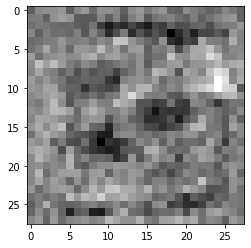

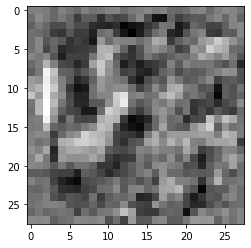

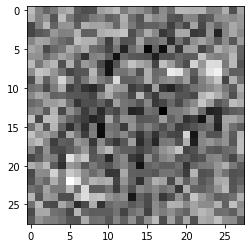

In [28]:
for i in range(10):
    weight = model.mylayer[0].weight[i, :].data.view(28, 28)
    weight = (weight - torch.min(weight))/(torch.max(weight)-torch.min(weight))
    plt.imshow(weight.numpy(), cmap='gray')
    plt.show()